In [1]:
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
random.seed(66)

data_path = "E:/Opossum_V1/Opossum_V1.h5ad"

adata = sc.read_h5ad(data_path)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 29685 × 29786
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_id', 'bc', 'ar_id', 'umi.counts', 'barcodes', 'gene.counts.0', 'gene.counts.1', 'gene.counts.4', 'gene.counts.8', 'gene.counts.16', 'gene.counts.32', 'gene.counts.64', 'exclude', 'exp_component_name', 'exp_component_vendor_name', 'batch', 'batch_vendor_name', 'tube', 'tube_internal_name', 'tube_contents_nm', 'tube_contents_nm_from_vendor', 'tube_avg_size_bp', 'tube_input_fmol', 'r1_index', 'r2_index', 'index_sequence_pair', 'organism', 'reference_id', 'facs_container', 'sample_name', 'patched_cell_container', 'cell_name', 'cell_id', 'studies', 'hemisphere_name', 'sample_quantity_count', 'expc_cell_capture', 'sample_quantity_pg', 'donor_name', 'external_donor_name', 'age', 'species', 'sex', 'control', 'cell_prep_type', 'full_genotype', 'facs_population_plan', 'cre_line', 'reporter', 'injection_roi', 'injection_method', 'injection_materials', 'injection_type', 'roi', 'patchseq_

In [7]:
adata.X

<29685x29786 sparse matrix of type '<class 'numpy.float64'>'
	with 82127395 stored elements in Compressed Sparse Column format>

In [32]:
from scipy.io import mmwrite
import gzip
import shutil

def compress_file(input_filename, output_filename):
    with open(input_filename, 'rb') as f_in:
        with gzip.open(output_filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

for sample in np.unique(adata.obs["donor_name"]):
    temp_adata = adata[adata.obs["donor_name"] == sample, :].copy()
    path = "E:/Opossum_V1/output/" + sample + "/"
    print(temp_adata)
    mmwrite(path + "matrix.mtx", temp_adata.X.astype("int64").T, precision=1)
    temp_adata.var.index.to_frame().to_csv(path + "features.tsv", index=False, header=False)
    temp_adata.obs.index.to_frame().to_csv(path + "barcodes.tsv", index=False, header=False)
    for fl in ["matrix.mtx", "features.tsv", "barcodes.tsv"]:
        compress_file(path + fl, path + fl + ".gz")

AnnData object with n_obs × n_vars = 5887 × 29786
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_id', 'bc', 'ar_id', 'umi.counts', 'barcodes', 'gene.counts.0', 'gene.counts.1', 'gene.counts.4', 'gene.counts.8', 'gene.counts.16', 'gene.counts.32', 'gene.counts.64', 'exclude', 'exp_component_name', 'exp_component_vendor_name', 'batch', 'batch_vendor_name', 'tube', 'tube_internal_name', 'tube_contents_nm', 'tube_contents_nm_from_vendor', 'tube_avg_size_bp', 'tube_input_fmol', 'r1_index', 'r2_index', 'index_sequence_pair', 'organism', 'reference_id', 'facs_container', 'sample_name', 'patched_cell_container', 'cell_name', 'cell_id', 'studies', 'hemisphere_name', 'sample_quantity_count', 'expc_cell_capture', 'sample_quantity_pg', 'donor_name', 'external_donor_name', 'age', 'species', 'sex', 'control', 'cell_prep_type', 'full_genotype', 'facs_population_plan', 'cre_line', 'reporter', 'injection_roi', 'injection_method', 'injection_materials', 'injection_type', 'roi', 'patchseq_r

In [29]:
temp_adata.X.astype("int64").T

<29786x3271 sparse matrix of type '<class 'numpy.int64'>'
	with 10902684 stored elements in Compressed Sparse Row format>

In [20]:
for c in adata.obs.columns:
    print(c)

orig.ident
nCount_RNA
nFeature_RNA
sample_id
bc
ar_id
umi.counts
barcodes
gene.counts.0
gene.counts.1
gene.counts.4
gene.counts.8
gene.counts.16
gene.counts.32
gene.counts.64
exclude
exp_component_name
exp_component_vendor_name
batch
batch_vendor_name
tube
tube_internal_name
tube_contents_nm
tube_contents_nm_from_vendor
tube_avg_size_bp
tube_input_fmol
r1_index
r2_index
index_sequence_pair
organism
reference_id
facs_container
sample_name
patched_cell_container
cell_name
cell_id
studies
hemisphere_name
sample_quantity_count
expc_cell_capture
sample_quantity_pg
donor_name
external_donor_name
age
species
sex
control
cell_prep_type
full_genotype
facs_population_plan
cre_line
reporter
injection_roi
injection_method
injection_materials
injection_type
roi
patchseq_roi
medical_conditions
slice_min_pos
slice_max_pos
rna_amplification_set
rna_amplification
method
amp_date
pcr_cycles
percent_cdna_longer_than_400bp
rna_amplification_pass_fail
amplified_quantity_ng
load_name
port_well
library_prep_

In [15]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=8)

filtered out 3575 cells that have less than 500 genes expressed
filtered out 6870 genes that are detected in less than 8 cells


In [21]:
mito_genes = adata.var_names.str.startswith('mt-')
adata.obs['percent_mito'] = 100 * (np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1))

In [22]:
adata.obs["n_UMIs"] = np.sum(adata.X, axis=1).astype(int)

In [23]:
adata = adata[adata.obs["percent_mito"] < 10, :]
adata = adata[adata.obs["n_genes"] < 8000, :]
adata = adata[adata.obs["n_UMIs"] < 100000, :]

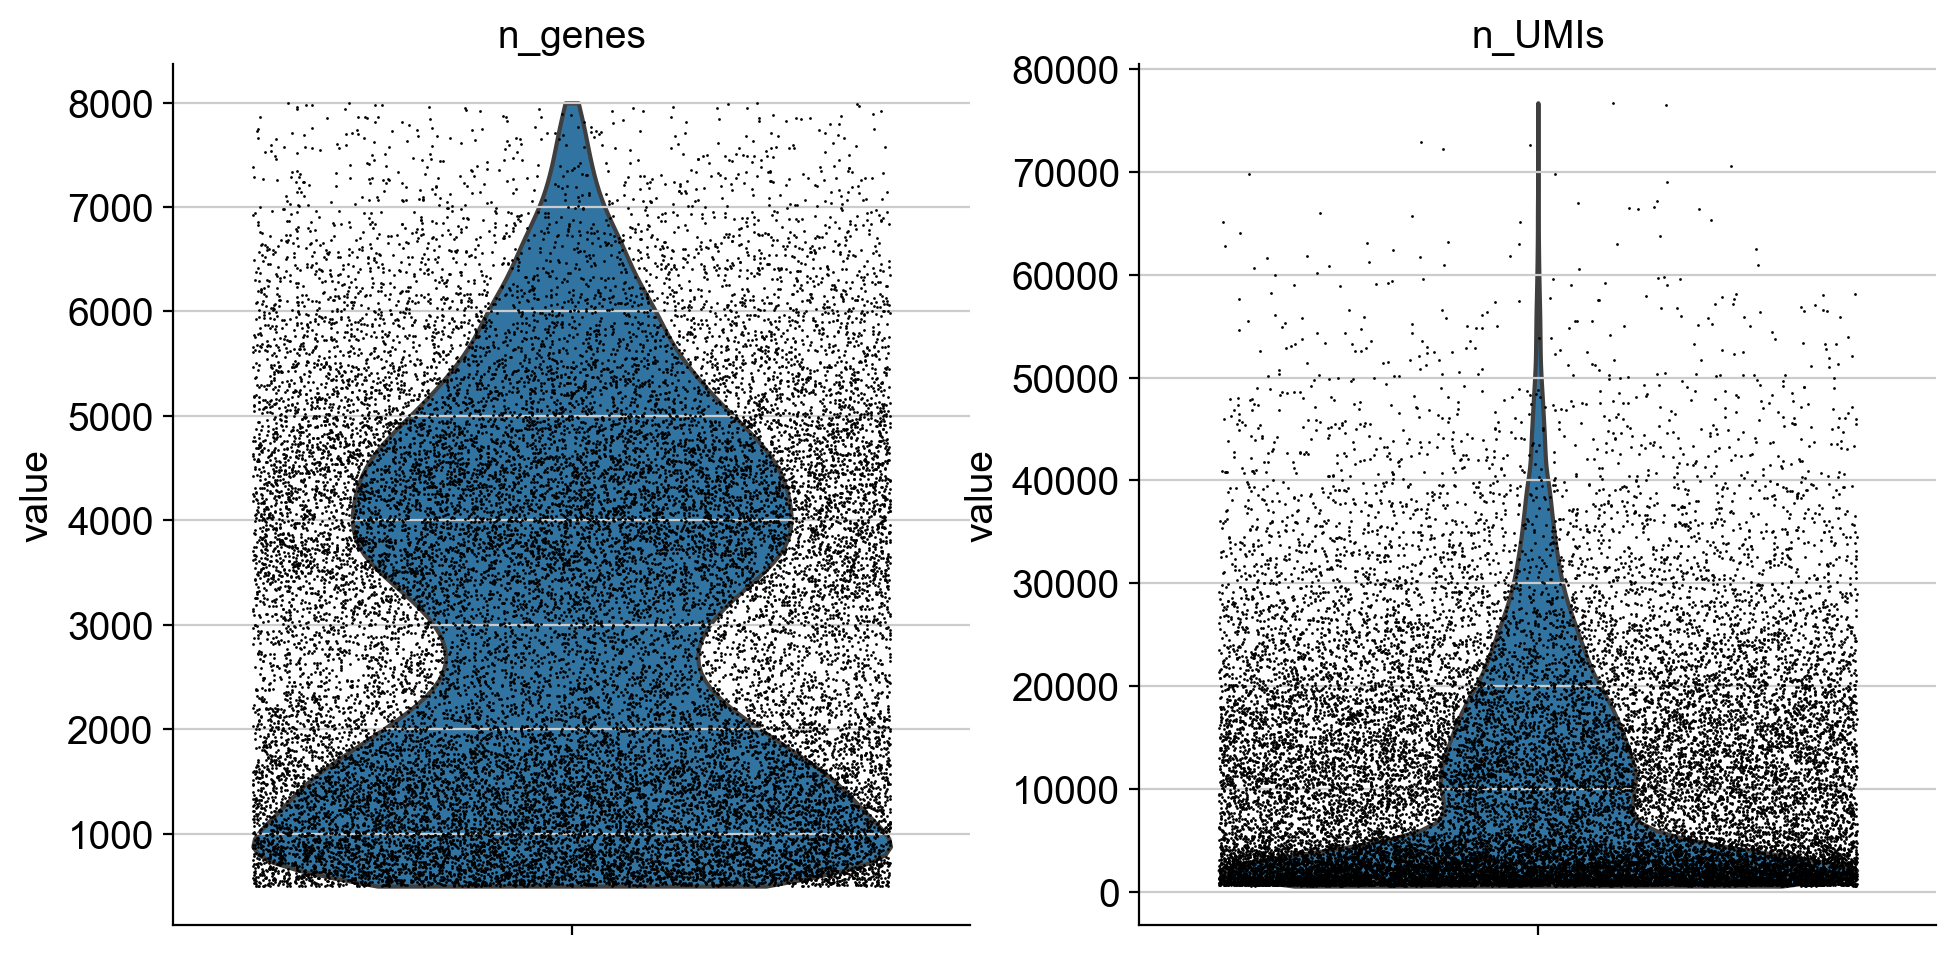

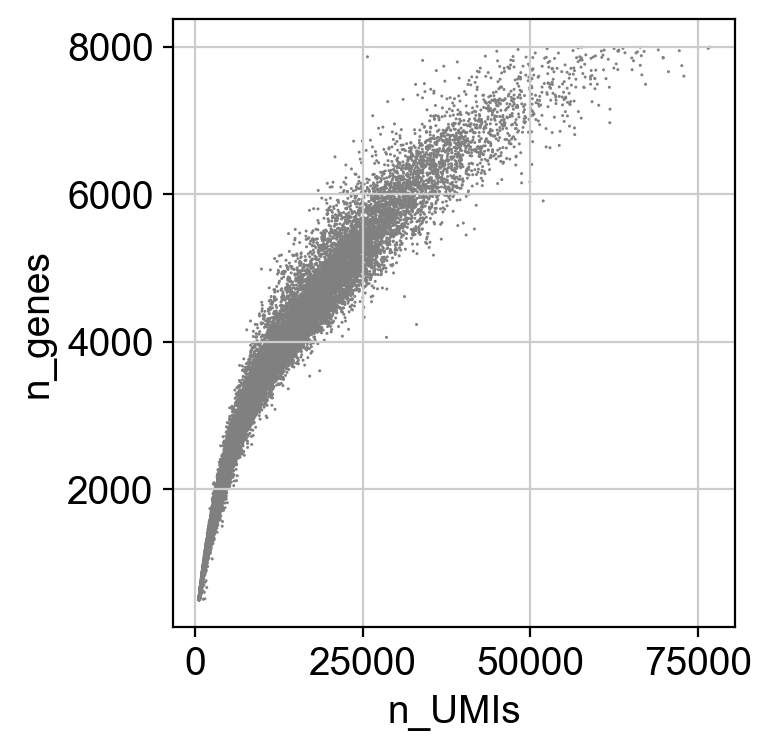

In [24]:
sc.pl.violin(adata, ["n_genes", "n_UMIs"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x="n_UMIs", y="n_genes")

In [25]:
adata_raw = adata.copy()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

normalizing by total count per cell


C:\Ryan\GitHub\scanpy\scanpy\preprocessing\_simple.py:523: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:08)


2024-03-29 18:19:29,030 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-29 18:19:36,505 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-29 18:19:36,716 - harmonypy - INFO - Iteration 1 of 20
2024-03-29 18:19:47,499 - harmonypy - INFO - Iteration 2 of 20
2024-03-29 18:19:58,415 - harmonypy - INFO - Iteration 3 of 20
2024-03-29 18:20:09,147 - harmonypy - INFO - Iteration 4 of 20
2024-03-29 18:20:19,820 - harmonypy - INFO - Iteration 5 of 20
2024-03-29 18:20:30,503 - harmonypy - INFO - Iteration 6 of 20
2024-03-29 18:20:41,342 - harmonypy - INFO - Iteration 7 of 20
2024-03-29 18:20:52,056 - harmonypy - INFO - Converged after 7 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 30 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


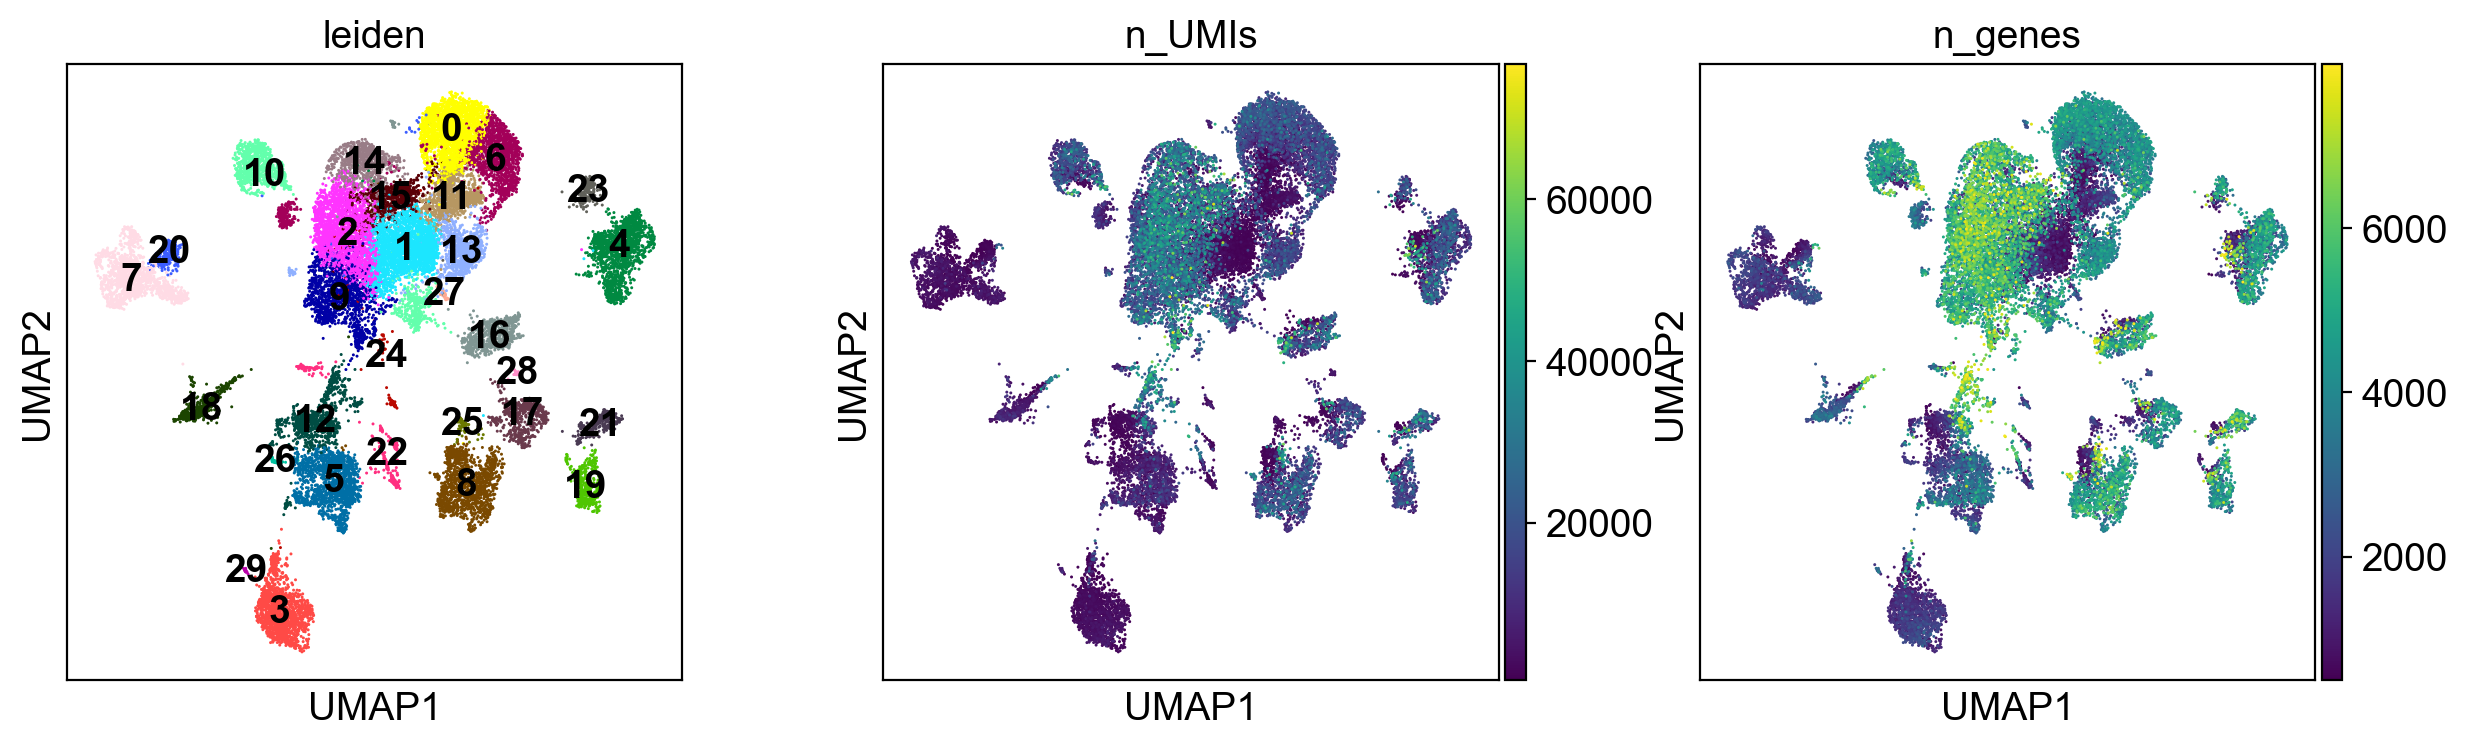

In [40]:
import scanpy.external as sce
sc.tl.pca(adata, svd_solver="arpack")
sce.pp.harmony_integrate(adata, "donor_name", theta=2, max_iter_harmony=20)
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca_harmony')
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden", "n_UMIs", "n_genes"], legend_loc="on data")

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


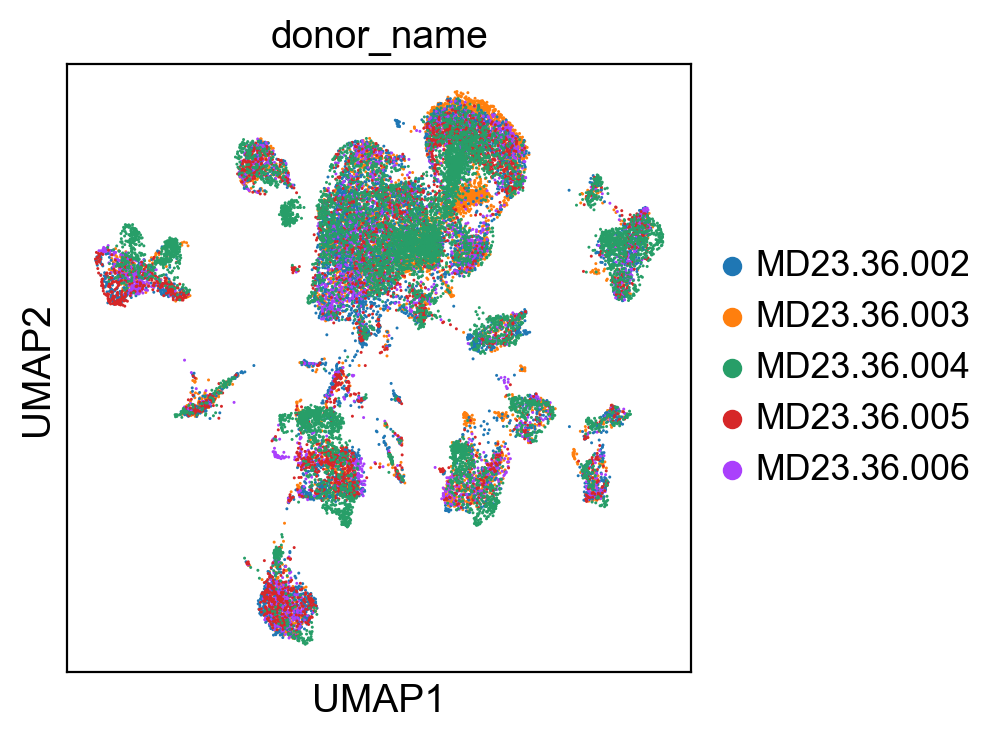

In [41]:
sc.pl.umap(adata, color=["donor_name"])

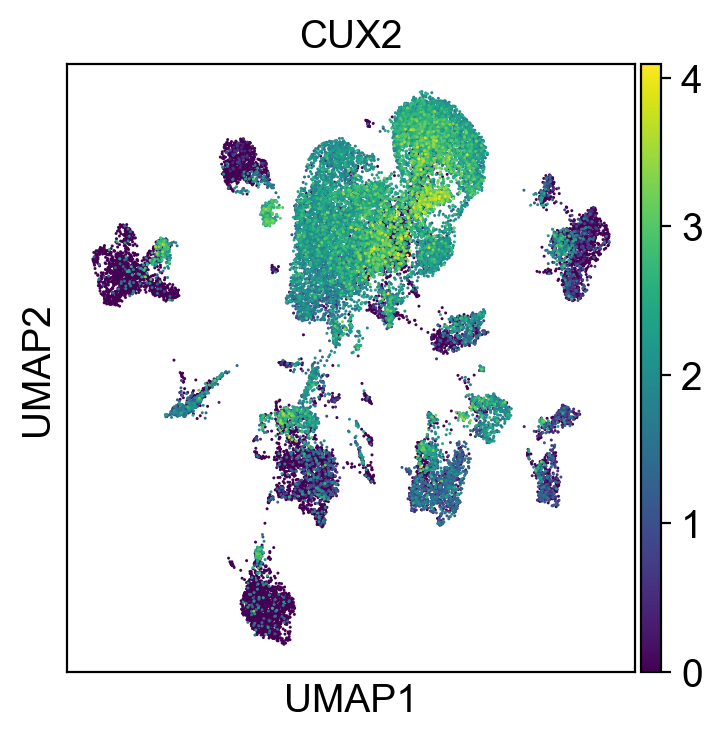

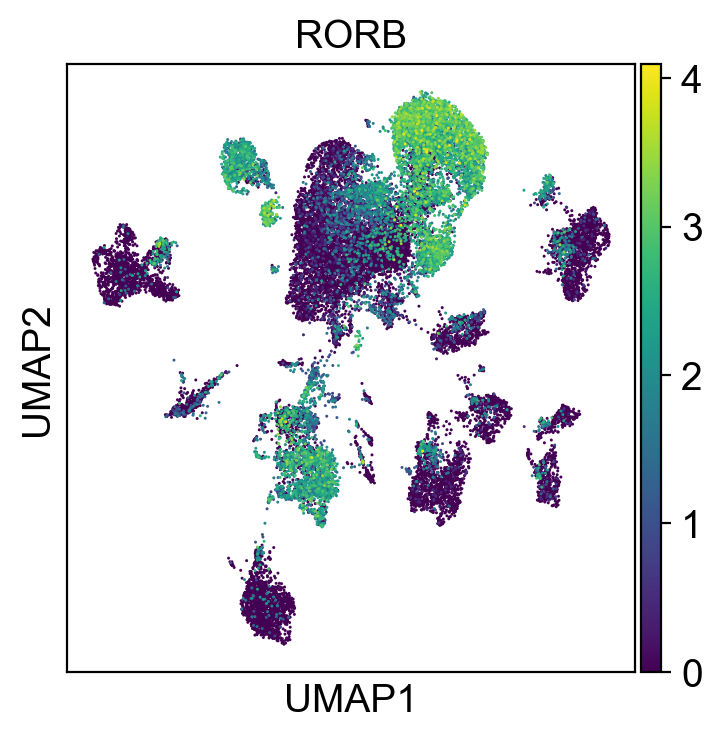

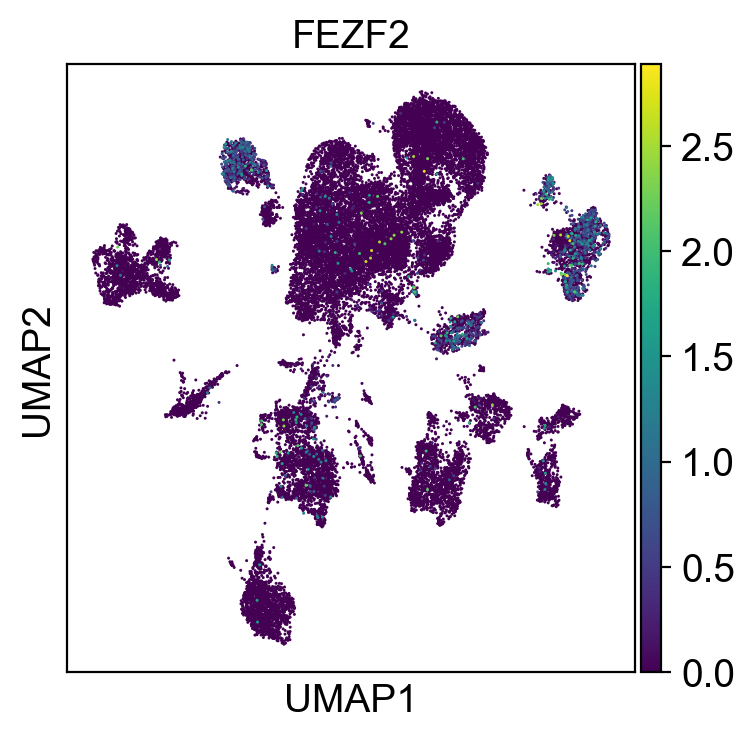

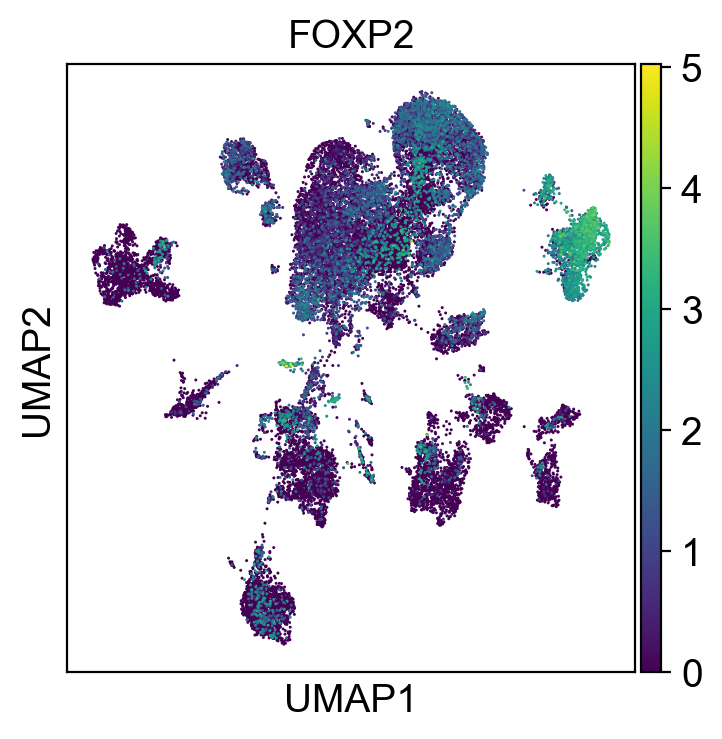

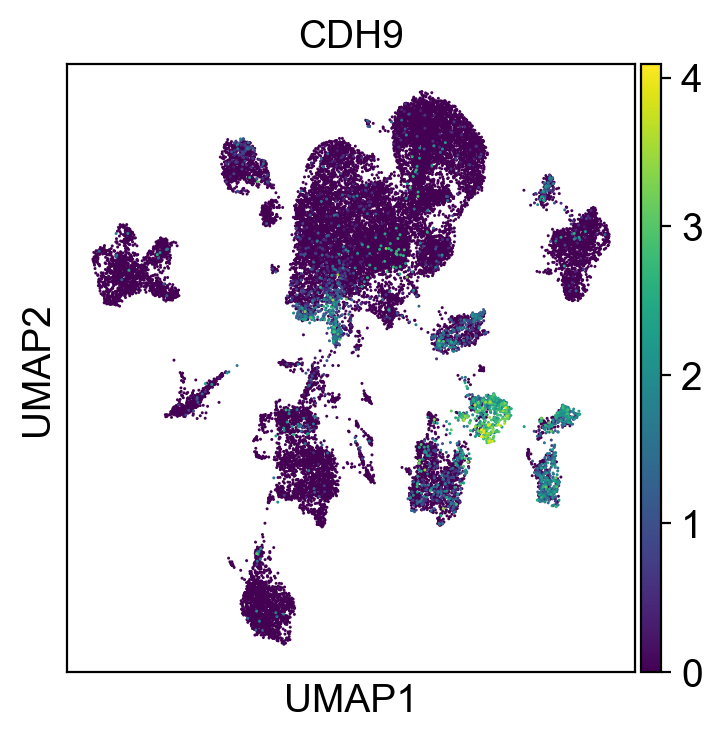

In [42]:
sc.pl.umap(adata, color=["CUX2"])
sc.pl.umap(adata, color=["RORB"])
sc.pl.umap(adata, color=["FEZF2"])
sc.pl.umap(adata, color=["FOXP2"])
sc.pl.umap(adata, color=["CDH9"])

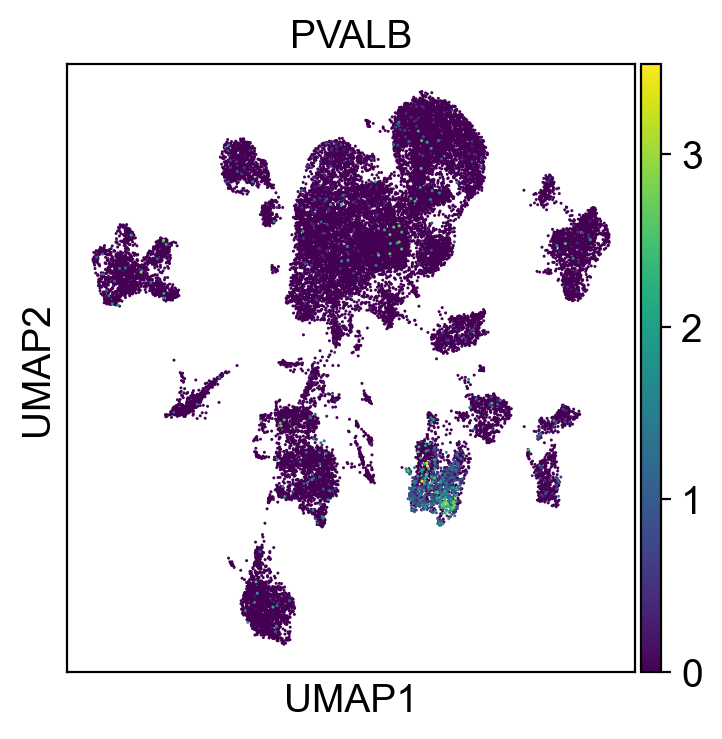

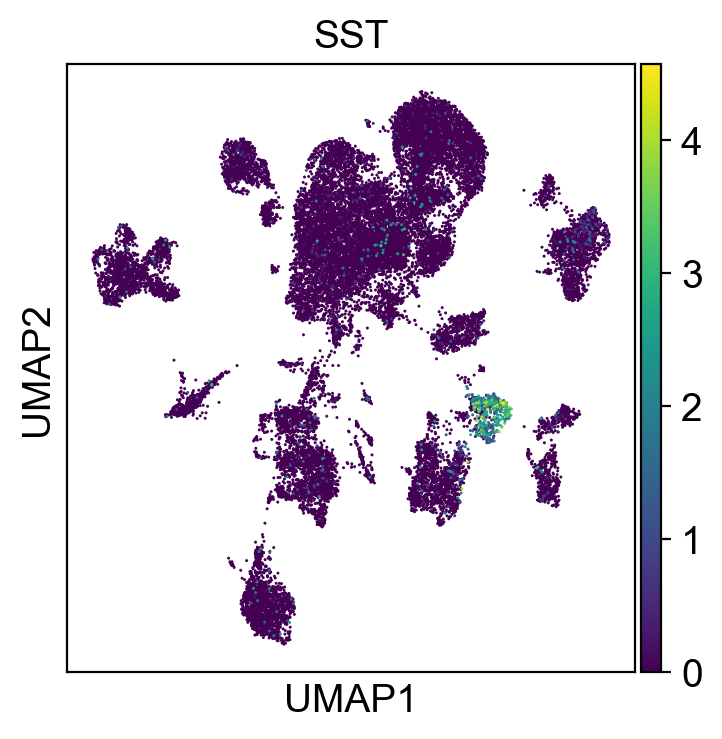

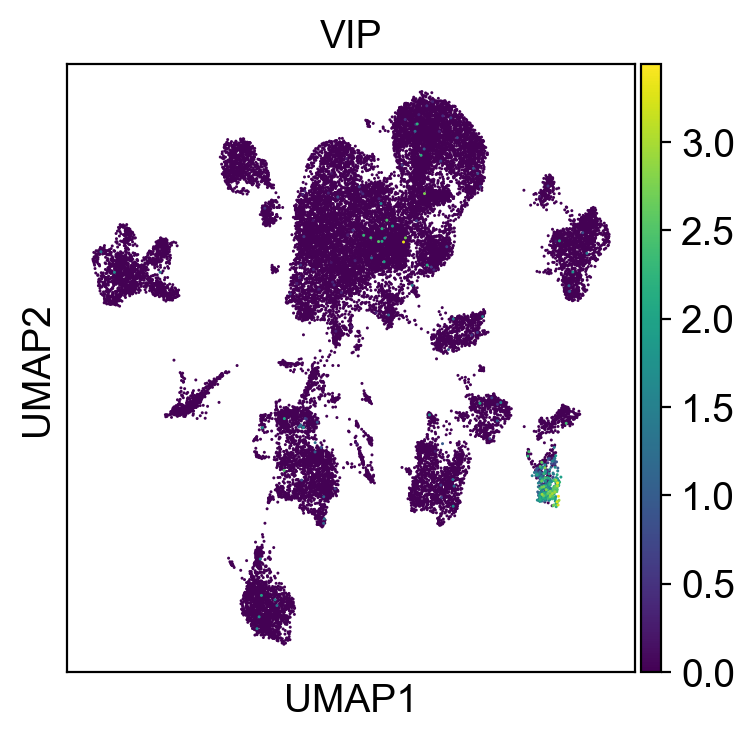

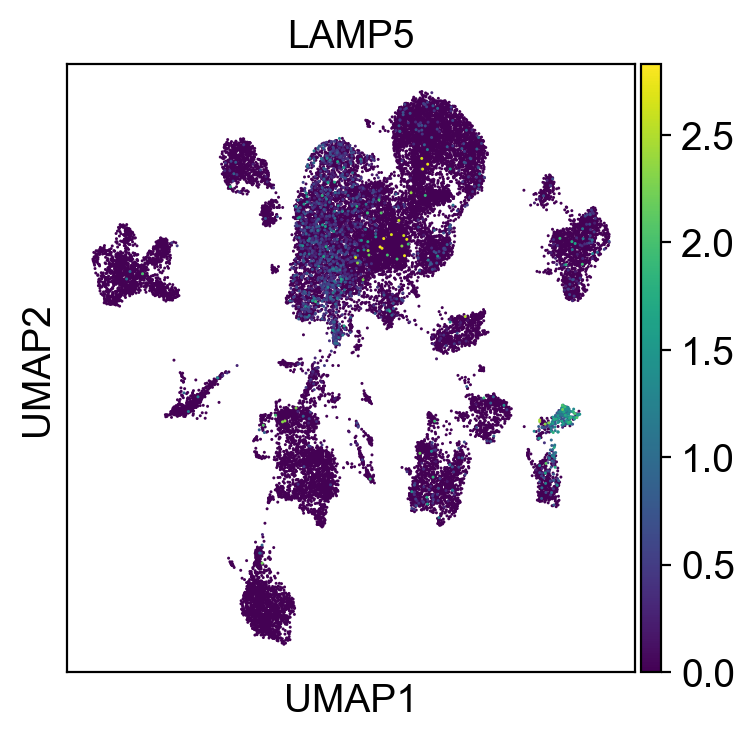

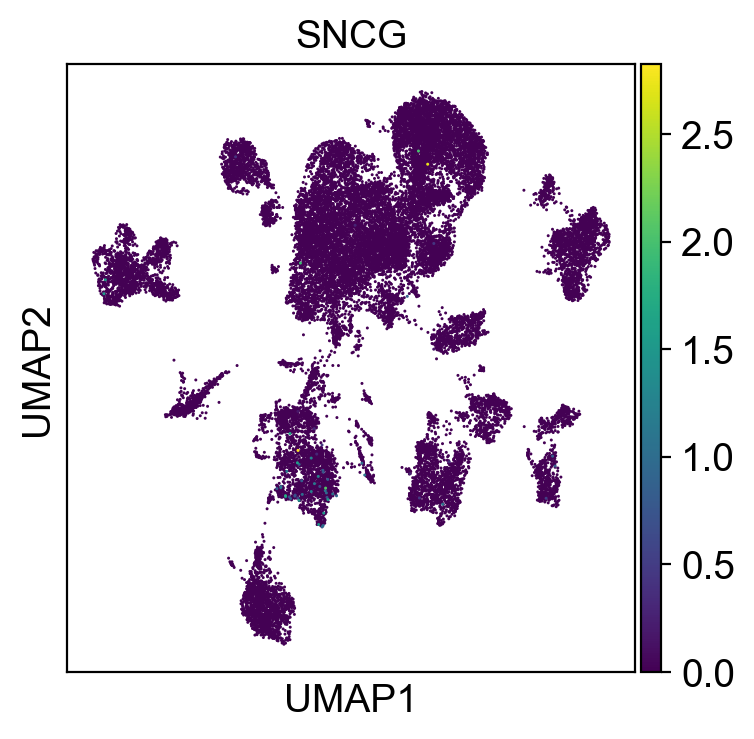

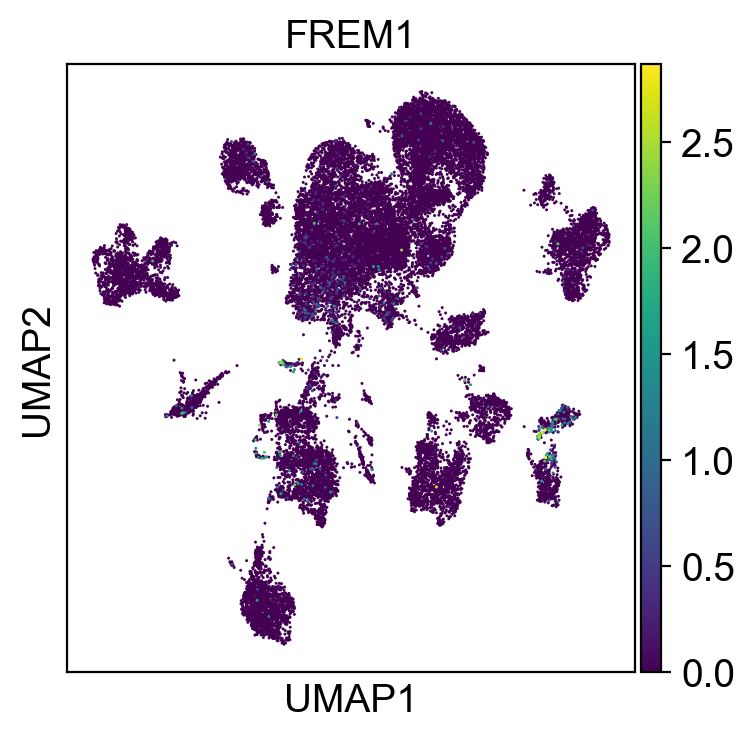

In [43]:
sc.pl.umap(adata, color=["PVALB"])
sc.pl.umap(adata, color=["SST"])
sc.pl.umap(adata, color=["VIP"])
sc.pl.umap(adata, color=["LAMP5"])
sc.pl.umap(adata, color=["SNCG"])
sc.pl.umap(adata, color=["FREM1"])

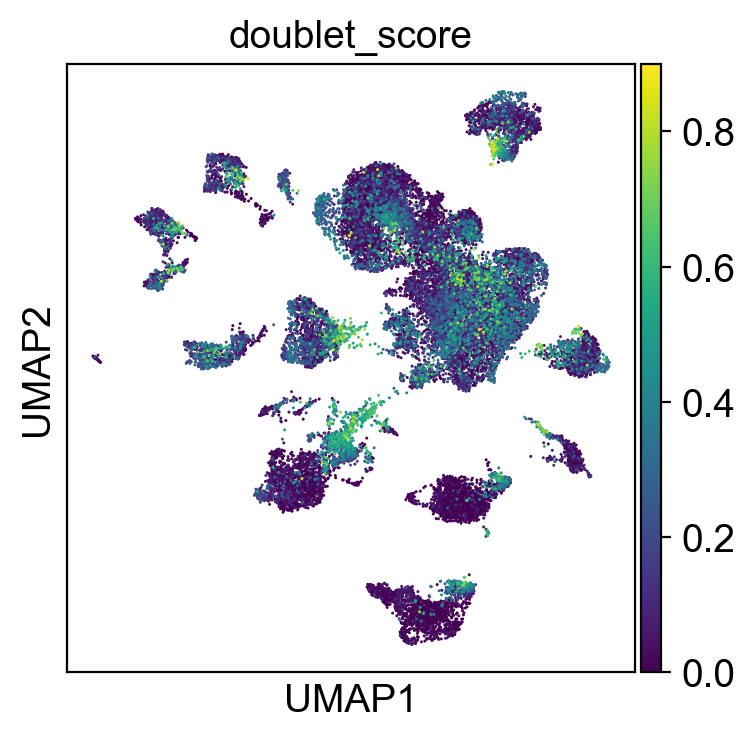

In [29]:
sc.pl.umap(adata, color=["doublet_score"])

In [13]:
class_idx = {
        "GABAergic" : ["7", "17", "19", "22", "28", "30"], 
            }

adata.obs["class"] = [None] * adata.shape[0]

for name, idx in class_idx.items():
    mask = np.isin(adata.obs["leiden"], idx)
    adata.obs.loc[mask, "class"] = [name] * np.sum(mask)

In [ ]:
ncells = []
for cl in ["7", "17", "20", "21"]:
    ncells.append(np.sum(adata.obs["leiden"] == cl))

In [ ]:
ncells = np.array(ncells)
props = ncells / np.sum(ncells)
props

array([0.52106262, 0.20910816, 0.16470588, 0.10512334])

In [15]:
save_path = "E:/Opossum_V1/"

adata_raw.obs = adata.obs
adata_raw.write_h5ad(save_path + "Opossum_V1_All.h5ad")

adata.write_h5ad(save_path + "Opossum_V1_All_Clustered.h5ad")

# for classname, filename in zip(["glutamatergic", "GABAergic", "non-neuronal"], ["Glut", "GABA", "Non"]):
for classname, filename in zip(["GABAergic"], ["GABA"]):
    
    adata_class = adata_raw[adata_raw.obs["class"] == classname, :]
    del adata_class.uns
    del adata_class.obsm
    del adata_class.varm
    del adata_class.obsp
    # adata_class.var = adata_class.var[["gene_ids", "feature_types"]]

    adata_class.write_h5ad(save_path + "Opossum_V1_" + filename + ".h5ad")